<img src="../logo_UTN.svg" align="right" width="150" /> 

#### Teoría de los Circuitos 2

# Trabajo semanal 8 - Laboratorio de filtros digitales
#### Lugano Damian

-------------------------

### Parte 1: Diseño de filtros

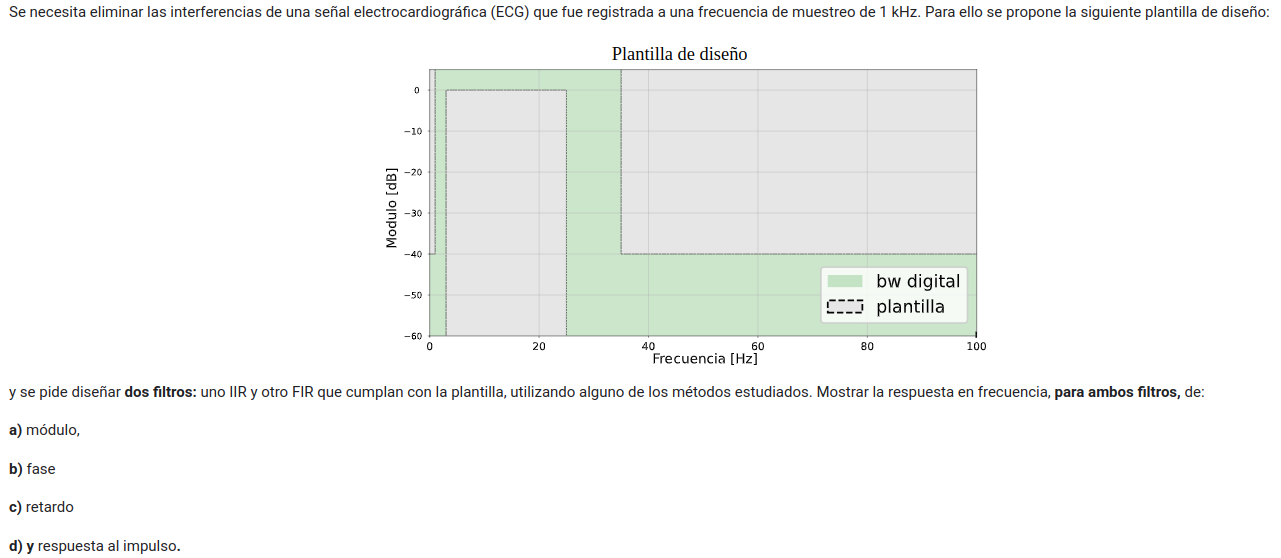

### Desarrollo

In [29]:
# Inicialización e importación de módulos

# Módulos para Jupyter
import warnings
warnings.filterwarnings('ignore')

# Módulos importantantes
import scipy.signal as sig
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
from pytc2.sistemas_lineales import plot_plantilla

fig_sz_x = 10
fig_sz_y = 7
fig_dpi = 100 # dpi

fig_font_size = 16

mpl.rcParams['figure.figsize'] = (fig_sz_x,fig_sz_y)
plt.rcParams.update({'font.size':fig_font_size})

In [30]:
###
## Señal de ECG registrada a 1 kHz, con contaminación de diversos orígenes.
###

# para listar las variables que hay en el archivo
mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

fs = 1000 # Hz
nyq_frec = fs / 2

In [31]:
# Plantilla

# filter design
ripple = 0.5 # dB
atenuacion = 40 # dB

ws1 = 1.0 #Hz
wp1 = 3.0 #Hz
wp2 = 25.0 #Hz
ws2 = 35.0 #Hz

frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
gains = 10**(gains/20)

### Filtro IIR

In [32]:
system=sig.iirdesign(wp=[wp1, wp2], ws=[ws1, ws2], gpass=ripple, gstop=atenuacion, analog=False, ftype='butter', output='sos', fs=1000)
print(system.shape)


(15, 6)


El sistema IIR está caracterizado por 15 SOS. Por lo tanto es un IIR de orden 30

In [33]:
w, h=sig.sosfreqz(system, worN=2000, fs=fs)

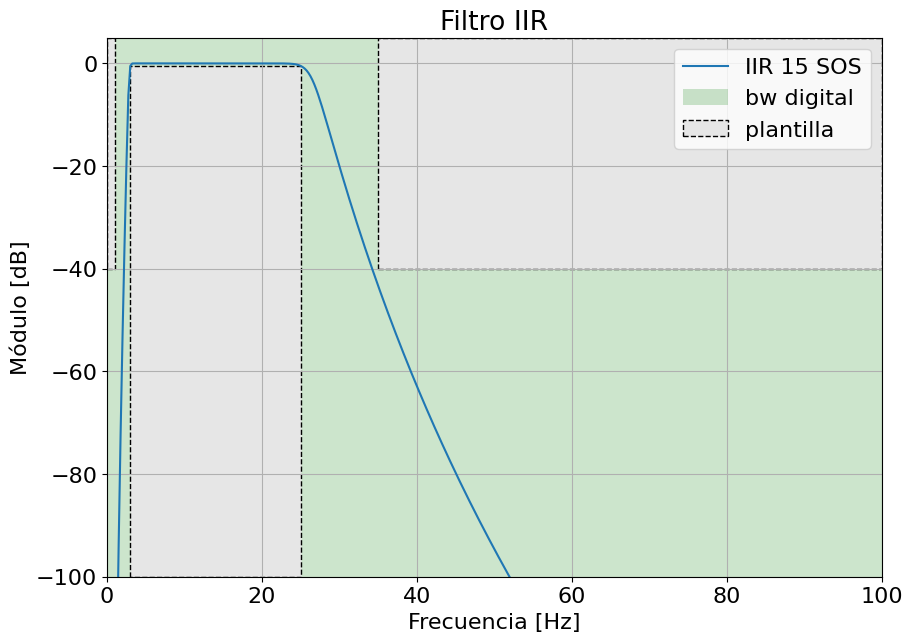

In [34]:
plt.plot(w, 20 * np.log10(abs(h)), label='IIR {:d} SOS'.format(system.shape[0]))

plt.title('Filtro IIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -100, 5 ])

plot_plantilla(filter_type = 'bandpass', fpass = [3,25], ripple = ripple , fstop = [1,35], attenuation = atenuacion, fs = fs)


(0.0, 100.0, -6.283185307179586, 6.283185307179586)

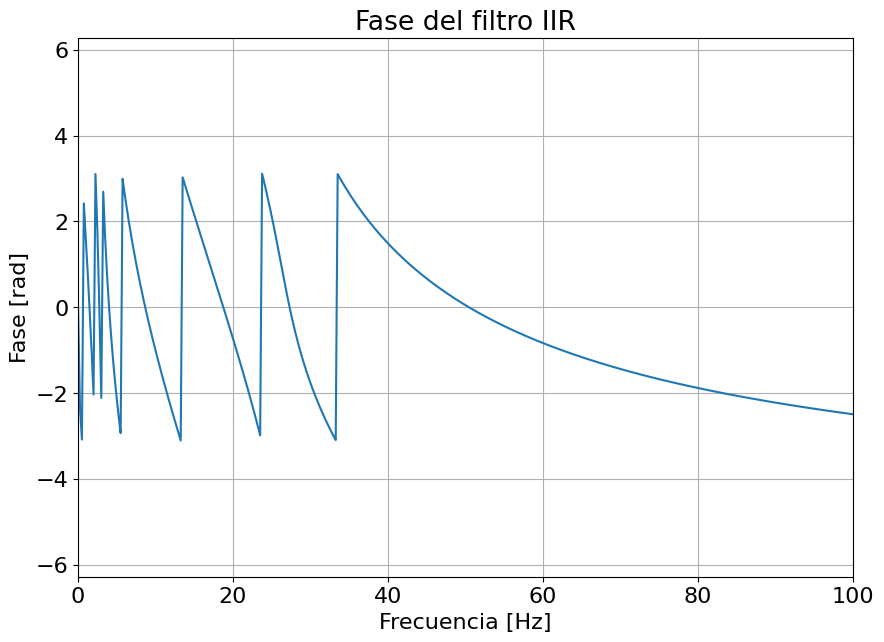

In [35]:
phase=np.angle(h)
plt.plot(w, phase)

plt.title('Fase del filtro IIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Fase [rad]')
plt.grid()
plt.axis([0, 100, -2*np.pi, 2*np.pi ])

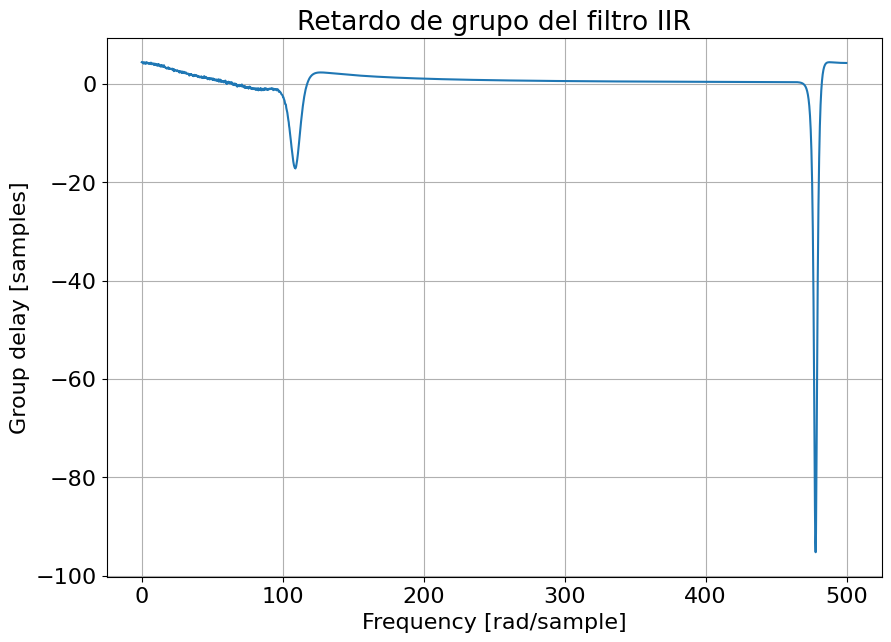

In [36]:
b,a = sig.sos2tf(system)
w, gd = sig.group_delay((b, a), w=2000, whole=False, fs=fs)

plt.title('Retardo de grupo del filtro IIR')
plt.plot(w, gd)
plt.ylabel('Group delay [samples]')
plt.xlabel('Frequency [rad/sample]')
plt.grid()

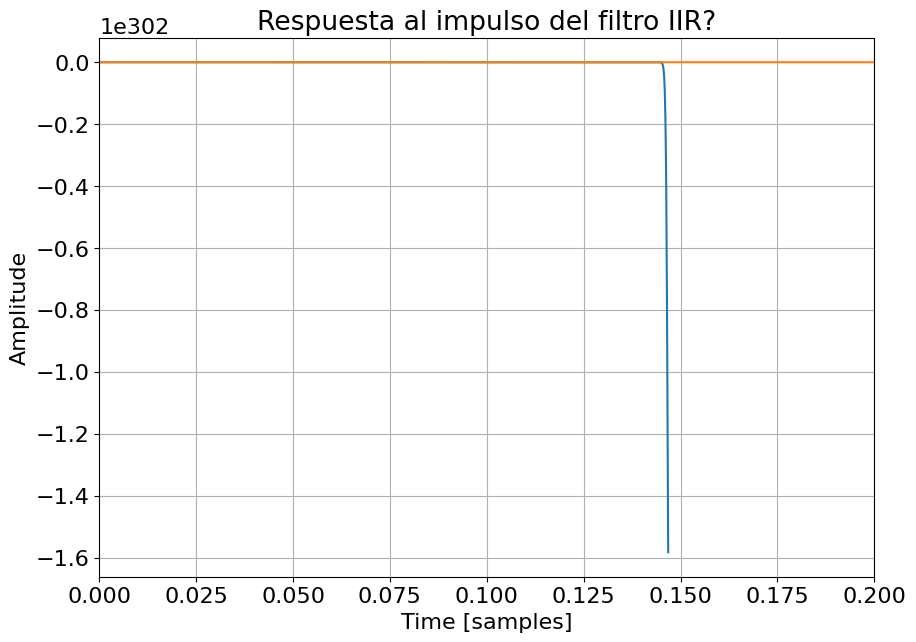

In [37]:
#### Respuesta al impulso del filtro IIR

imp = sig.unit_impulse(10000)
response = sig.lfilter(b, a, imp)

plt.plot(np.linspace(0,1, 10000), response)
plt.plot(np.linspace(0,1, 10000), imp)
plt.xlim([0,0.2])

plt.xlabel('Time [samples]')
plt.ylabel('Amplitude')
plt.title('Respuesta al impulso del filtro IIR?')

plt.grid(True)
plt.show()

### Filtro FIR

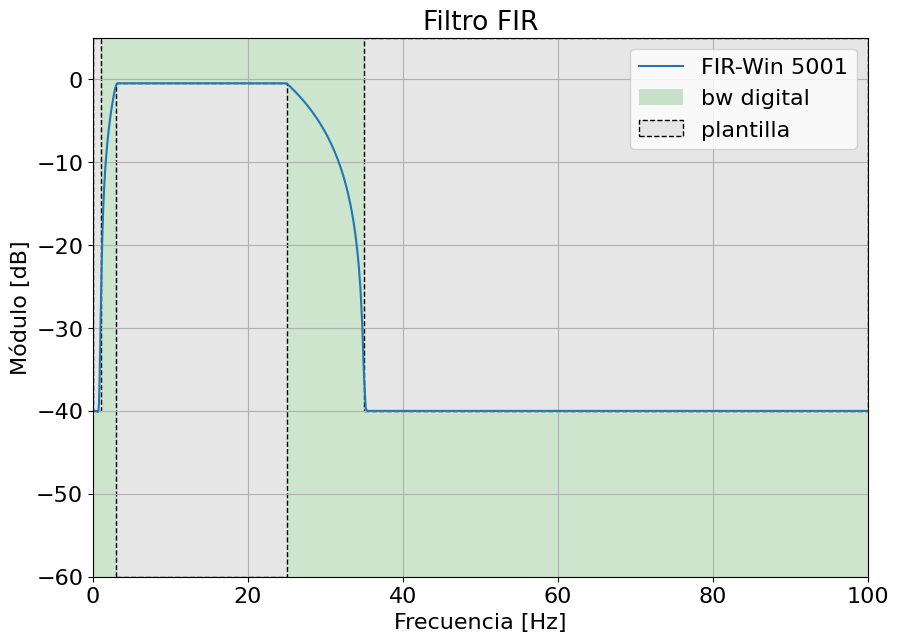

In [38]:
  
cant_coeficientes = 5001

num_win1 = sig.firwin2(cant_coeficientes, frecs, gains , window='hamming' )

den = 1.0

# muestreo el filtro donde me interesa verlo según la plantilla.
w  = np.append(np.logspace(-1, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w  = np.append(w, np.linspace(110, nyq_frec, 100, endpoint=True) ) / nyq_frec * np.pi

_,hh_win1 = sig.freqz(num_win1, den, w)

# renormalizo el eje de frecuencia
w = w / np.pi * nyq_frec

plt.plot(w, 20 * np.log10(abs(hh_win1)), label='FIR-Win {:d}'.format(num_win1.shape[0]))

plt.title('Filtro FIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -60, 5 ]);

axes_hdl = plt.gca()
axes_hdl.legend()

plot_plantilla(filter_type = 'bandpass', fpass = [3,25], ripple = ripple , fstop = [1,35], attenuation = atenuacion, fs = fs)


(0.0, 500.0, -6.283185307179586, 6.283185307179586)

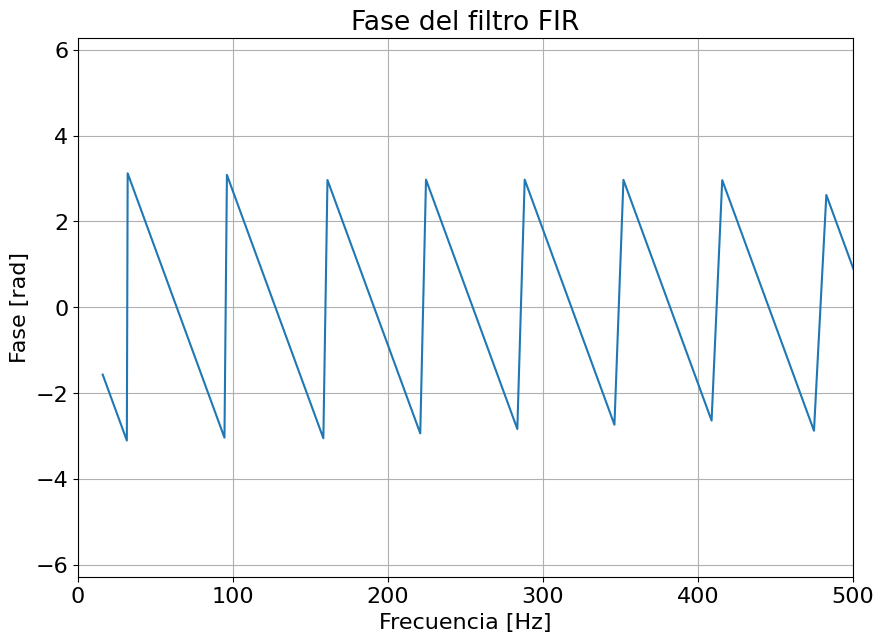

In [39]:
phase=np.angle(hh_win1)
plt.plot((w / np.pi * nyq_frec), phase)

plt.title('Fase del filtro FIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Fase [rad]')
plt.grid()
plt.axis([0, nyq_frec, -2*np.pi, 2*np.pi ])

(0.0, 500.0, 0.0, 5000.0)

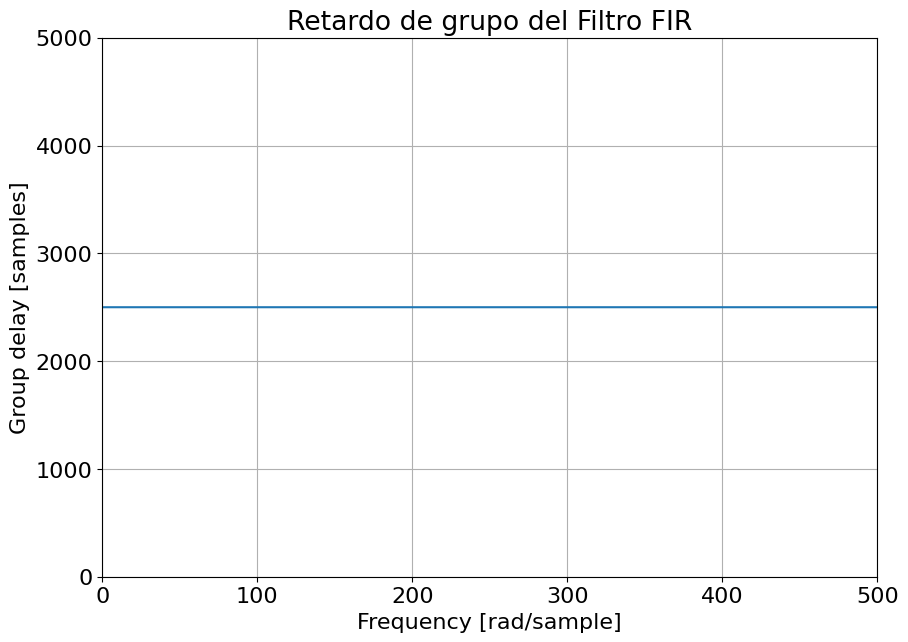

In [40]:
w, gd = sig.group_delay((num_win1, den), w=2000, whole=False, fs=fs)

plt.title('Retardo de grupo del Filtro FIR')
plt.plot(w, gd)
plt.ylabel('Group delay [samples]')
plt.xlabel('Frequency [rad/sample]')
plt.grid()
plt.axis([0, nyq_frec, 0, 5000])

In [41]:
print("Retardo de grupo constante típico de los filtros FIR = ", gd[250])

Retardo de grupo constante típico de los filtros FIR =  2499.9999999999777


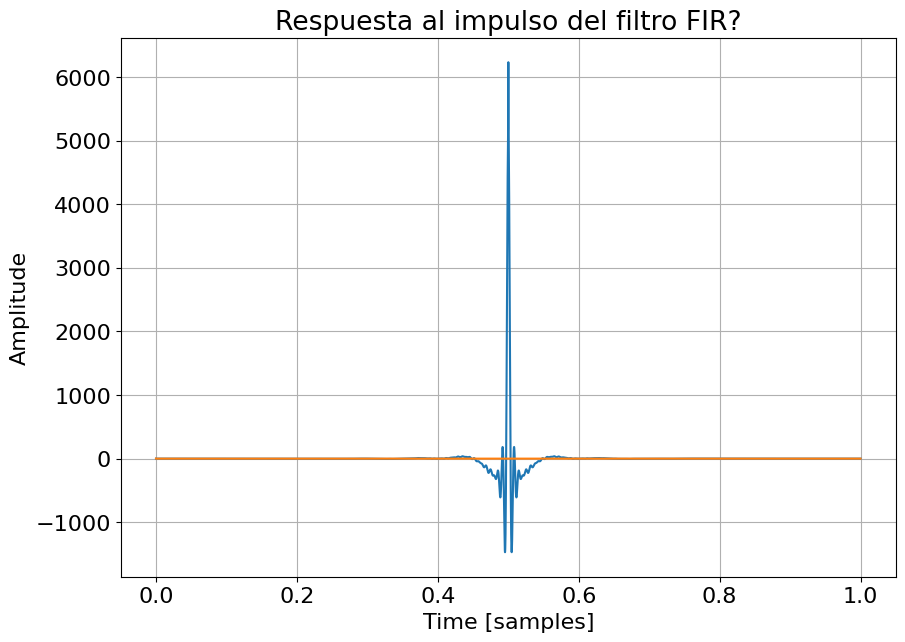

In [42]:
imp = sig.unit_impulse(5000)

den=np.zeros(5001)
den[0]=1

response = sig.lfilter(num_win1, den, imp)

plt.plot(np.linspace(0,1, 5000), response*(10**5))
plt.plot(np.linspace(0,1, 5000), imp)
##plt.ylim([0,10])

plt.xlabel('Time [samples]')
plt.ylabel('Amplitude')
plt.title('Respuesta al impulso del filtro FIR?')

plt.grid(True)
plt.show()

In [43]:
print(response)

[-1.64922313e-08 -1.71935728e-08 -1.91102170e-08 ... -2.20940841e-08
 -1.91102170e-08 -1.71935728e-08]


### FIR pasa-bajo+pasa-alto

In [44]:
# Plantilla

# filter design
ripple = 0.1 # dB
atenuacion = 40 # dB

ws1 = 1.0 #Hz
wp1 = 3.0 #Hz
wp2 = 25.0 #Hz
ws2 = 35.0 #Hz

frecs_high = np.array([0.0, ws1, wp1, nyq_frec]) / nyq_frec
gains_high = np.array([-atenuacion, -atenuacion, -ripple, -ripple])

frecs_low = np.array([0.0, wp2, ws2, nyq_frec]) / nyq_frec
gains_low = np.array([-ripple, -ripple, -atenuacion, -atenuacion])

gains_high = 10**(gains_high/20)
gains_low = 10 **(gains_low/20)

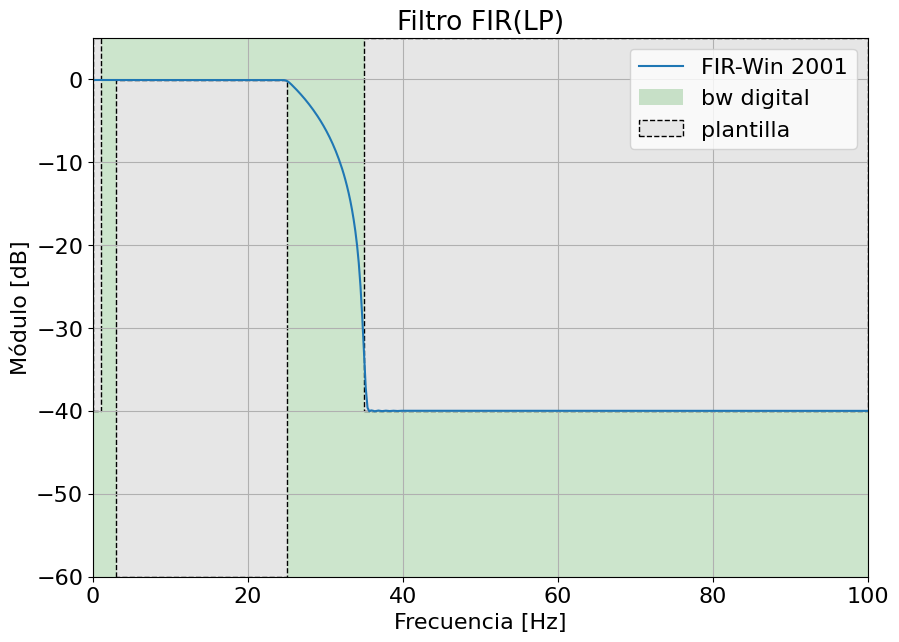

In [45]:
## Filtro pasa bajo con wp2=25Hz y ws2=35Hz

cant_coeficientes = 2001

beta=sig.kaiser_beta(atenuacion)

num_win_low = sig.firwin2(cant_coeficientes, frecs_low, gains_low , window=('kaiser', beta))

den = 1.0

# muestreo el filtro donde me interesa verlo según la plantilla.
w  = np.append(np.logspace(-1, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w  = np.append(w, np.linspace(110, nyq_frec, 100, endpoint=True) ) / nyq_frec * np.pi

_,hh_win_low = sig.freqz(num_win_low, den, w)

# renormalizo el eje de frecuencia
w = w / np.pi * nyq_frec

plt.plot(w, 20 * np.log10(abs(hh_win_low)), label='FIR-Win {:d}'.format(num_win_low.shape[0]))

plt.title('Filtro FIR(LP)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -60, 5 ]);

axes_hdl = plt.gca()
axes_hdl.legend()

plot_plantilla(filter_type = 'bandpass', fpass = [3,25], ripple = ripple , fstop = [1,35], attenuation = atenuacion, fs = fs)


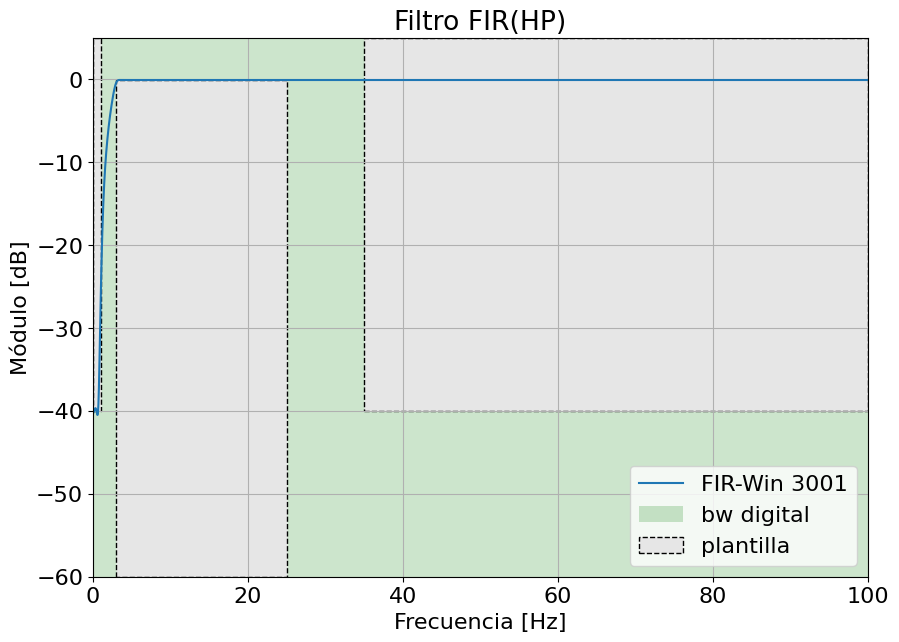

In [46]:
## Filtro pasa altos con ws1=1Hz y wp1=3Hz

cant_coeficientes = 3001

num_win_high = sig.firwin2(cant_coeficientes, frecs_high, gains_high , window=('kaiser', beta))

den = 1.0

# muestreo el filtro donde me interesa verlo según la plantilla.
w  = np.append(np.logspace(-1, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w  = np.append(w, np.linspace(110, nyq_frec, 100, endpoint=True) ) / nyq_frec * np.pi

_,hh_win_high = sig.freqz(num_win_high, den, w)

# renormalizo el eje de frecuencia
w = w / np.pi * nyq_frec

plt.plot(w, 20 * np.log10(abs(hh_win_high)), label='FIR-Win {:d}'.format(num_win_high.shape[0]))

plt.title('Filtro FIR(HP)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -60, 5 ])

axes_hdl = plt.gca()
axes_hdl.legend()

plot_plantilla(filter_type = 'bandpass', fpass = [3,25], ripple = ripple , fstop = [1,35], attenuation = atenuacion, fs = fs)


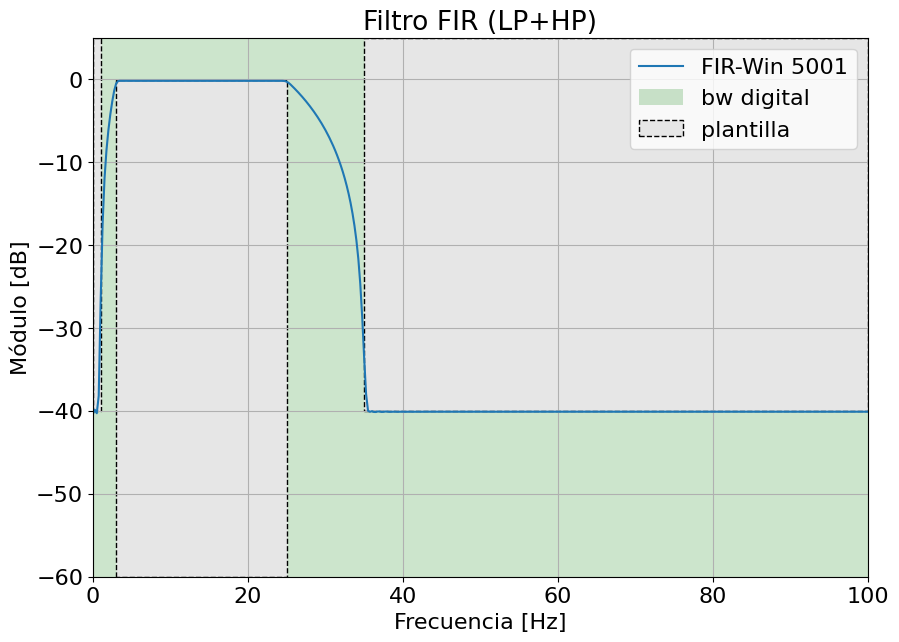

In [47]:
## Suma de los dos filtros en un filtro final

num_win2= np.polymul(num_win_high, num_win_low)

w_win,hh_win2 = sig.freqz(num_win2, a=1, worN=2000)

plt.plot(((w_win) / np.pi * nyq_frec), 20 * np.log10(abs(hh_win2)), label='FIR-Win {:d}'.format(num_win2.shape[0]))

plt.title('Filtro FIR (LP+HP)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -60, 5 ])

axes_hdl = plt.gca()
axes_hdl.legend()

plot_plantilla(filter_type = 'bandpass', fpass = [3,25], ripple = ripple , fstop = [1,35], attenuation = atenuacion, fs = fs)


(0.0, 500.0, -6.283185307179586, 6.283185307179586)

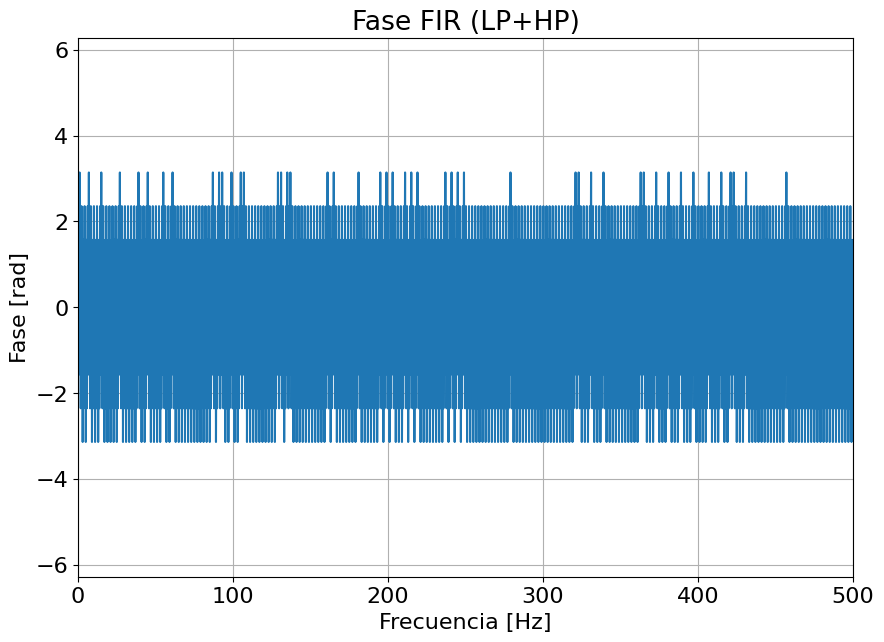

In [48]:
phase=np.angle(hh_win2)
plt.plot(((w_win) / np.pi * nyq_frec), phase)

plt.title('Fase FIR (LP+HP)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Fase [rad]')
plt.grid()
plt.axis([0, 500, -2*np.pi, 2*np.pi ])

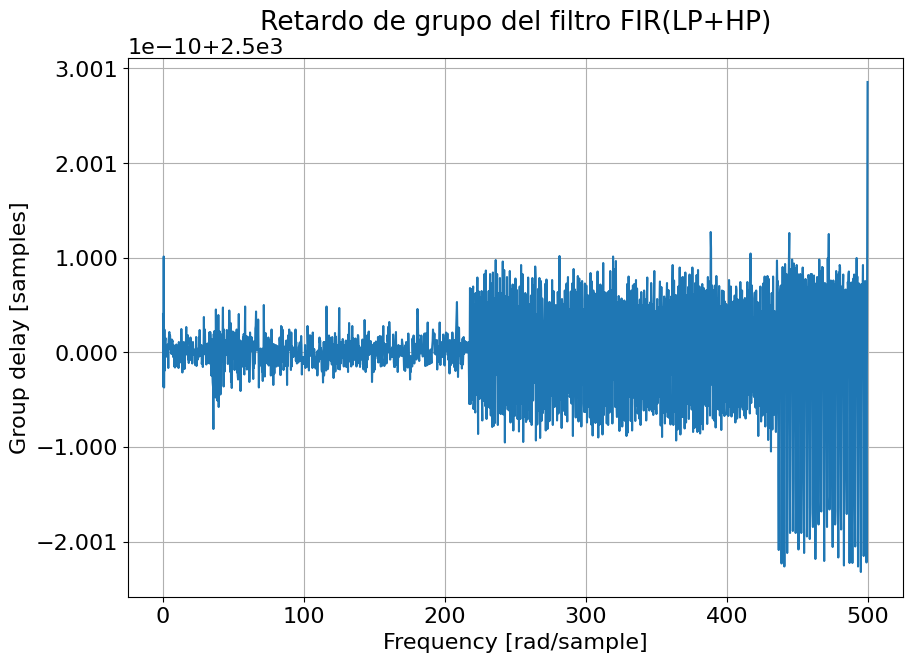

In [49]:
w, gd = sig.group_delay((num_win2, den), w=2000, whole=False, fs=fs)

plt.title('Retardo de grupo del filtro FIR(LP+HP)')
plt.plot(w, gd)
plt.ylabel('Group delay [samples]')
plt.xlabel('Frequency [rad/sample]')
plt.grid()

La fase y el retardo de grupoo del filtro FIR hecho mediante la multiplicación de los coeficientes de los numeradores de los respectivos filtros pasa bajo y pasa alto no se graficó correctamente. Por lo tanto, para la parte 2 se utilizó el filtro diseñado con la función firwin2().

### Parte 2


Una vez diseñados los filtros procedemos a utilizarlos. Para ello SciPy dispone de dos implementaciones de la ecuación de diferencias, la tradicional mediante lfilter y la variante por SOS's mediante sosfilt. La primera puede usarse para filtros FIR de cualquier tamaño, e IIR de bajo orden (<= 3 secciones u orden 6), mientras que la segunda es obligatoria para filtros IIR de orden superior.

In [50]:
# IIR
# ECG_f_butt = sig.sosfilt(bp_sos_butter, ecg_one_lead)

# FIR
ECG_f_win = sig.lfilter(num_win1, den, ecg_one_lead)

Ahora visualizamos los resultados, para ello se cuenta con diferentes regiones de interés (ROI's) para poder evaluar qué tan bien se comportan los filtros diseñados. Primero revisaremos zonas de **alta contaminación** para evaluar qué tan eficiente es el filtrado.

Recordar que **cada filtro impone una demora a la señal filtrada**, por lo tanto, dicha demora puede corregirse para cada filtro retrasando la señal de entrada o adelantando la señal de salida. Recuerde que como la señal ya fue registrada, una secuencia puede *adelantarse*.

In [51]:
#Se calcula el retardo del filtro para sincronizar la señal de entrada y salida

w, gd = sig.group_delay((num_win1, den), w=2000, whole=False, fs=fs)
demora=int(np.round(gd[250]))

print("Demora =",demora)

Demora = 2500


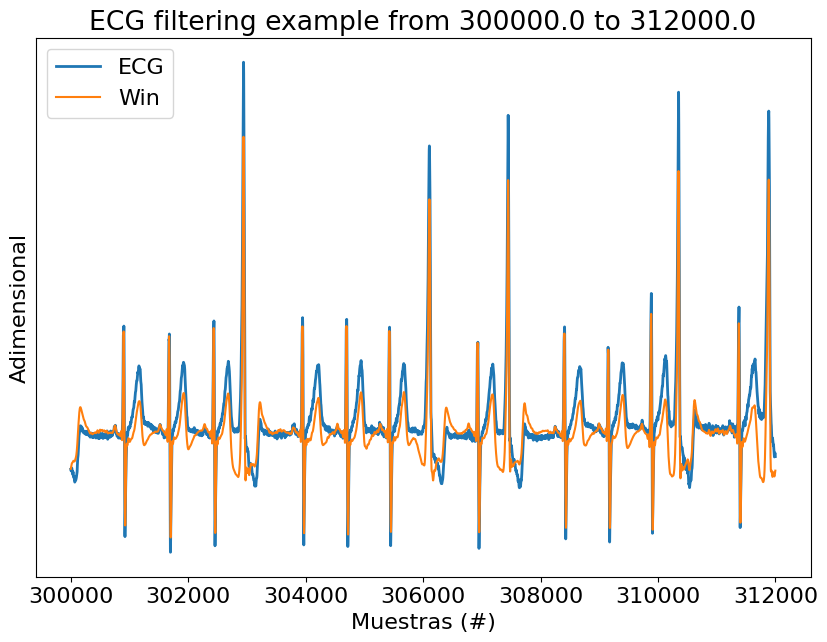

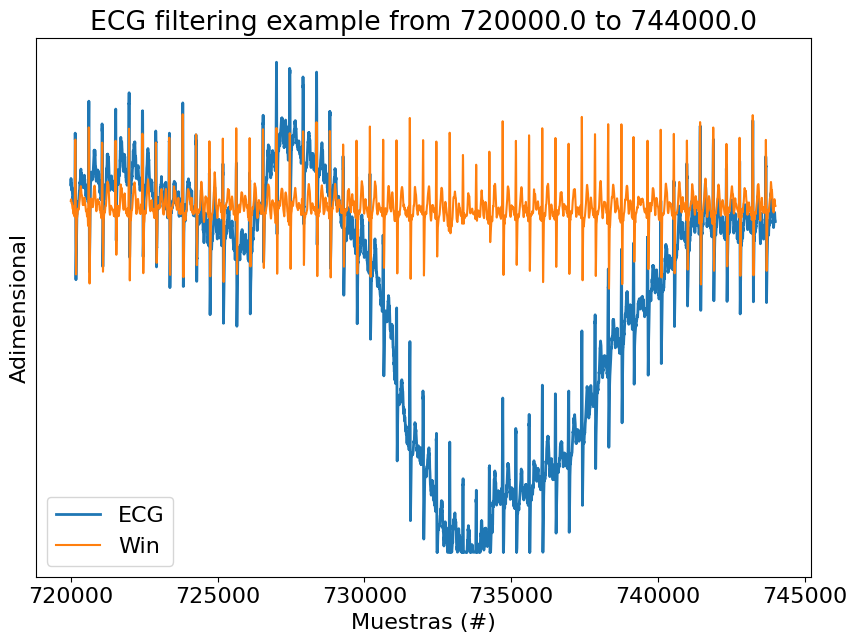

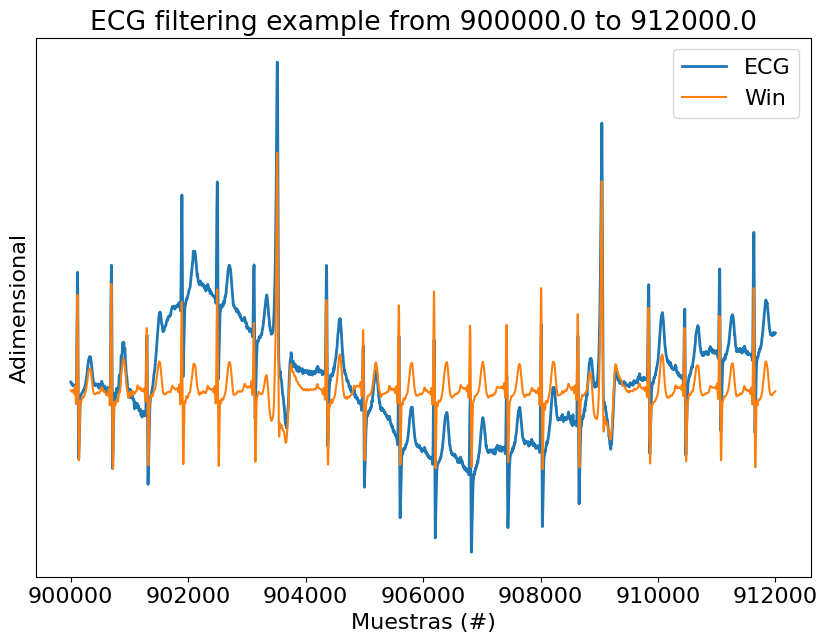

In [52]:
# Segmentos de interés con ALTA contaminación

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

Al analizar el efecto del filtrado, observamos que la señal original de ECG (en azul) posee contaminación de baja frecuencia en algunas zonas del registro. Dicha contaminación probablemente se deba al aumento de la actividad física durante la prueba de esfuerzo. Como se observa, la mayor parte de las técnicas de filtrados es *inocua* cuando no hay contaminación de baja frecuencia, y remueve los movimientos de la línea de base correctamente.

Ahora analizaremos cómo se han comportado los filtros analizando la señal en detalle para algunos latidos **con baja contaminación**, es decir qué tan **inocuo** es el filtro en su banda de paso. Desde luego nos interesará que la señal de ECG no haya sido alterada en su morfología, debido a que esto podría imposibilitar su uso como método de diagnóstico.

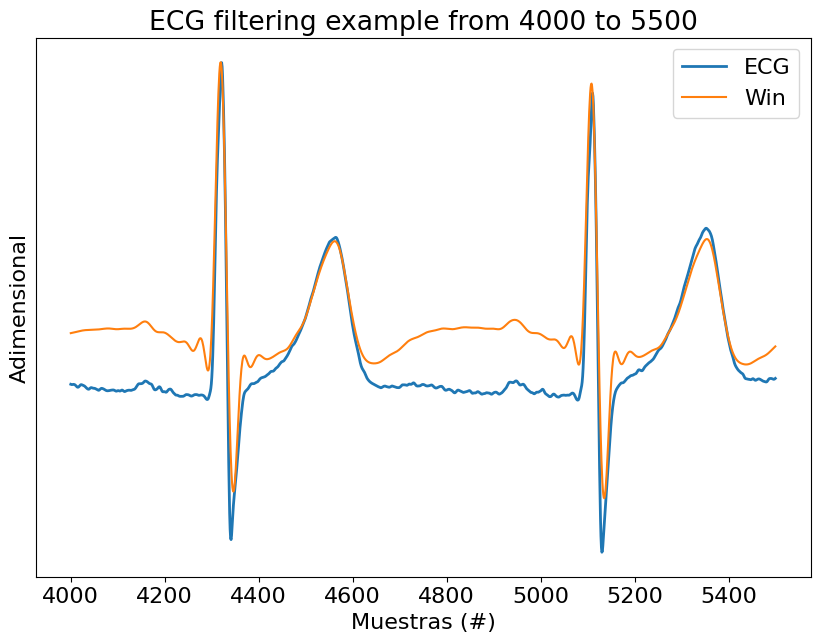

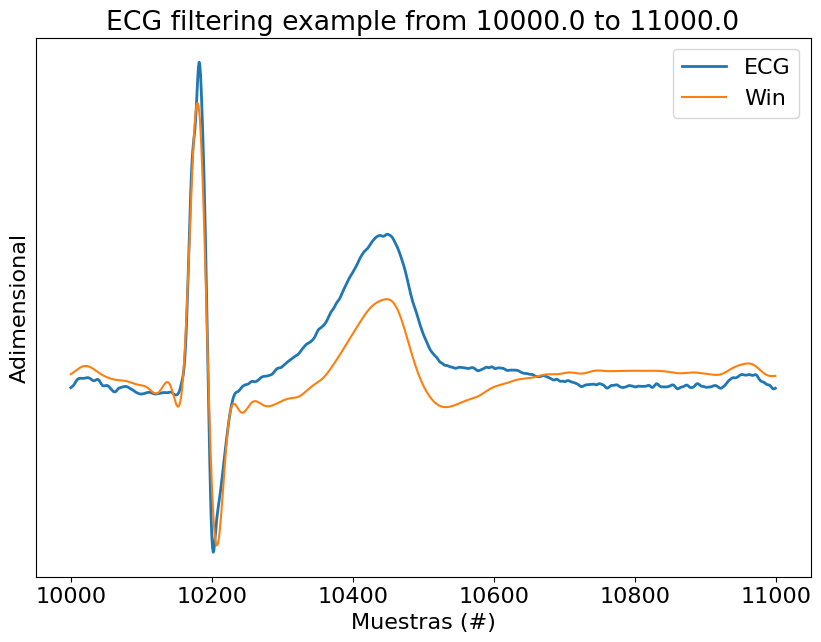

In [53]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())


Finalmente implementaremos **los mismos filtros** con una técnica diferente llamada *filtrado bidireccional* *[scipy.signal.filtfilt](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.signal.filtfilt.html)*.

El filtrado bidireccional es una técnica sumamente conveniente al momento de filtrar digitalmente una señal, dado que evita por completo cualquier distorsión de fase. Esto afecta principalmente a los filtros IIR, donde las distorsiones pueden ser notorias. Sin embargo, los filtros FIR cuya respuesta al impulso sea simétrica (par o simpar), **no** producen distorsión de fase debido a que su fase **es lineal**. 

En ambos casos, tanto para los IIR como para los FIR, simétricos o no, el resultado es una anulación completa de la respuesta de fase, obteniéndose así un **filtro de fase cero**. Recordemos que la transformada de Fourier de la inversión en tiempo es 

\begin{equation}
x[-k] \stackrel{\mathrm{DFT}}{\longleftrightarrow} X^*(e^{j \, \Omega })
\end{equation}

Por lo tanto, vemos que la inversión en tiempo conlleva la negación de la respuesta de fase de una señal. Entonces utilizaremos una doble inversión temporal para cancelar los efectos de fase, y al mismo tiempo el resultado neto sobre la señal espejada dos veces será nulo

\begin{equation}
Y(e^{j \, \Omega }) = X(e^{j \, \Omega }) \cdot T^*(e^{j \, \Omega }) \cdot T(e^{j \, \Omega }) 
\end{equation}

\begin{equation}
Y = X \cdot |T|^2
\end{equation}

*(Se simplificó la notación para clarificar el resultado)* Se observa como resultado de aplicar el método bidireccional un filtro equivalente al cuadrado del módulo y con aporte nulo de fase para todas las frecuencias. Esto equivale a haber atravesado dos veces por el mismo filtro, por lo tanto la atenuación será el doble que la del filtro original (y el *ripple* en banda también!) razón por lo cual debe modificarse la plantilla de diseño **relajando a la mitad** la atenuación, es decir exigiendo menos atenuación, pero **duplicando** la exigencia de ripple, es decir dividiendo por dos el ripple.

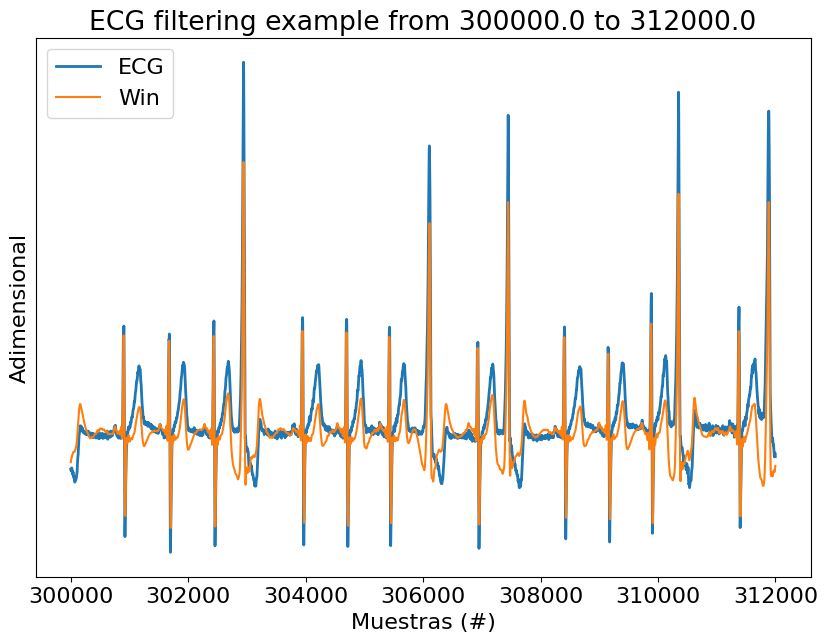

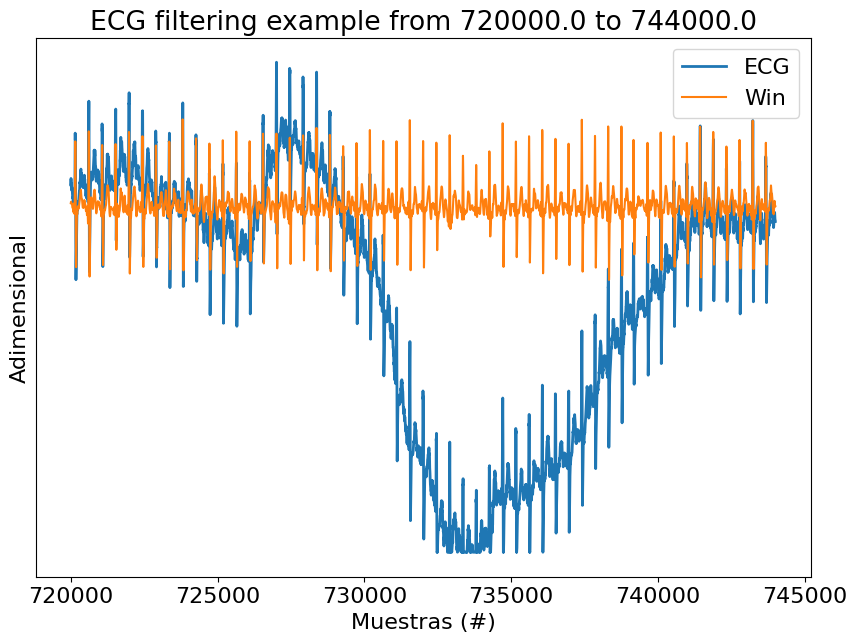

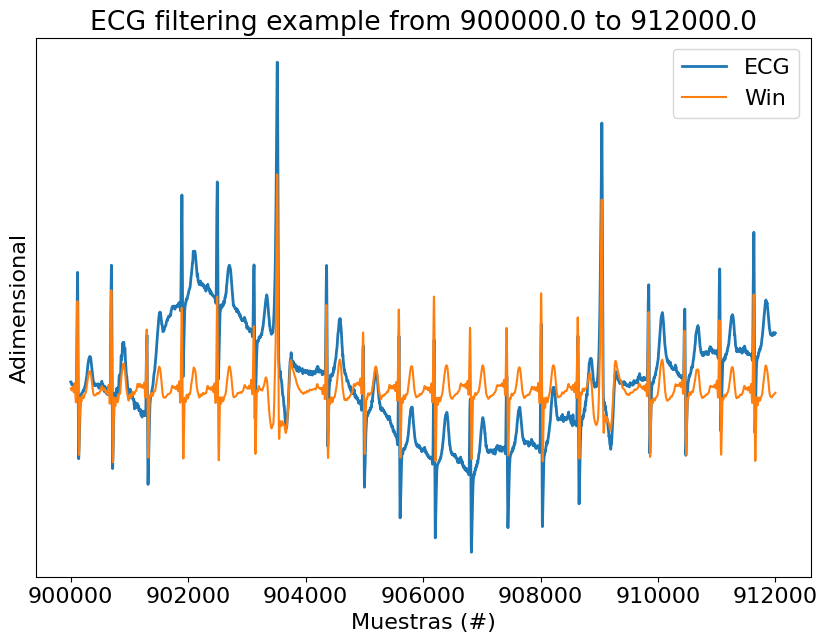

In [54]:
# Procedemos al filtrado
# ECG_f_butt = sig.sosfiltfilt(bp_sos_butter, ecg_one_lead)

ECG_f_win = sig.filtfilt(num_win1, den, ecg_one_lead)

# Segmentos de interés
regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

Volvemos a revisar los detalles menos contaminados:

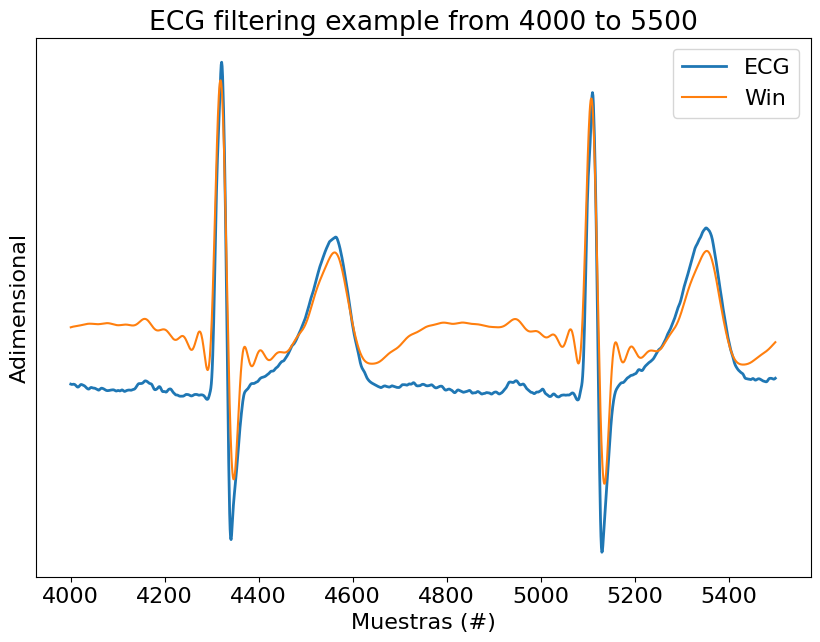

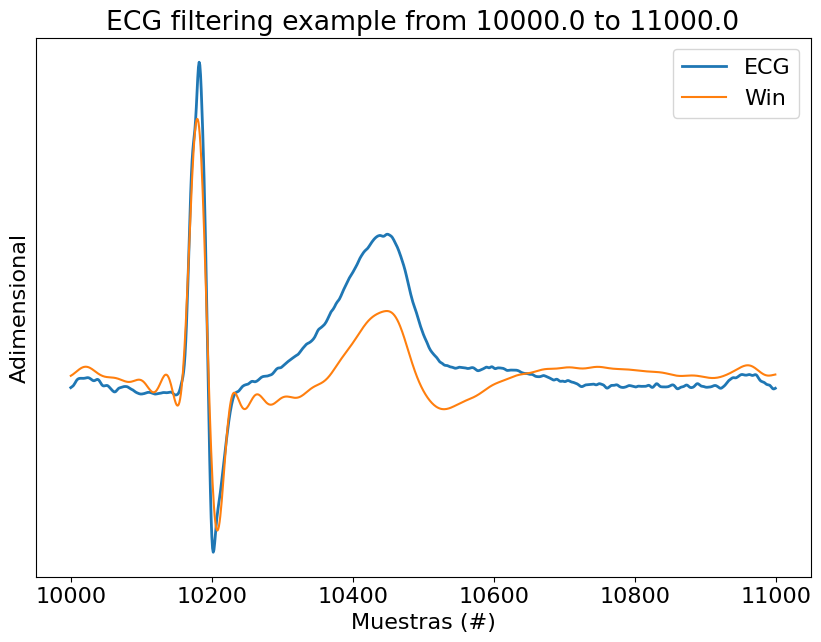

In [55]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

Como se observa, la señal de ECG ha sido alterada en su morfología, a pesar de que **la fase no pudo haber sido la responsable** luego de haber usado el filtrado bidireccional. El complejo de ondas QRS, es decir las primeras deflecciones rápidas de mayor energía relacionadas con la compresión muscular, han sido claramente atenuadas, mientras que la onda T, la segunda onda positiva de mayor duración y relacionada con la relajación muscular, ha sido también atenuada. También se observan otros artefactos ocasionados por el filtrado lineal, como **oscilaciones que no estaban presentes en el ECG original**. Estas observaciones dan cuenta, que estos filtros no son adecuados para esta tarea y es necesario su rediseño teniendo en cuenta estos aspectos.

Quedan pendiente las siguientes cuestiones, en caso que los filtros no se hayan comportado de acuerdo a lo esperado:

  1. ¿Qué pudo haber causado que los filtros no hayan sido **eficientes** para eliminar las interferencias? 
  2. ¿Qué pudo haber causado que los filtros no hayan sido **inocuos** respecto a las señales NO contaminadas? 
  
Y en caso que los filtros hayan funcionado como esperaba, reflexione sobre cómo los utilizaría en una arquitectura digital como las usadas en las **Informáticas** o las **Técnicas Digitales**.

1. Una posible razón por la cual los filtros pueden no haber funcionado eficazmente para eliminar las interferencias podría ser debido a la superposición del ruido en la misma banda de frecuencia que la señal de interés. Otra posibilidad es que la plantilla del filtro no sea adecuada y requiera ajustes.

2. Como se puede observar en la última experiencia, la fase no parece ser la responsable de haber alterado la morfología del ECG. Lo que hace que el filtro no sea efectivo es su respuesta al impulso, la cual es generada por la deflexión más rápida del ECG (R) que se asemeja a un delta de Dirac. Por lo tanto, es crucial reconsiderar el diseño del filtro teniendo en cuenta que su respuesta al impulso puede modificar la forma de la señal que se está analizando.

Si los filtros hubieran funcionado como se esperaba, sería necesario obtener la respuesta al impulso del filtro mediante la Transformada Rápida de Fourier (FFT) de su función de transferencia. Después, se debería ajustar la precisión de los coeficientes obtenidos de la respuesta al impulso para que coincidan con el tipo de datos más preciso admitido por el procesador. Finalmente, se requeriría implementar un algoritmo de convolución para poder aplicar la respuesta al impulso del filtro a cualquier entrada y así obtener la respuesta del filtro en la salida.